# Conditional Bernoulli Project

## I-Rejection Sampling


### Exploring the Impact of Sample Size, k Value, and Sample Variance on Acceptance Rate

In this section, we will experiment with varying the sample size, the target sum (`k` value), and the variance of the sample probabilities. Our goal is to observe how these factors influence the acceptance rate of the rejection sampling algorithm. By analyzing these relationships, we aim to gain insights into the behavior and efficiency of the sampling process under different conditions.


### Rejection sampler definition and acceptance for different sizes/k

In [24]:
import numpy as np
from joblib import Parallel, delayed

def rejection_sampler(p, k, n_samples=1000):
    
    """
    Generate samples from Bernoulli distributions conditioned on their sum being k.

    Parameters:
    - p: Probabilities for each Bernoulli variable.
    - k: Desired sum.
    - n_samples: Number of samples to generate.

    Returns:
    - accepted_samples: Array of valid samples.
    - attempts: Total number of attempts.
    """
    p = np.array(p)
    N = len(p)
    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < n_samples:
        # Generate a sample of N independent Bernoulli random variables
        sample = np.random.rand(N) < p
        attempts += 1
        # Check if the sum equals k
        if sample.sum() == k:
            accepted_samples.append(sample)
    
    return np.array(accepted_samples), attempts



# Dictionary to store acceptance rates for each size and k
acceptance_rates = {}

# Implement the algorithm for different p arrays of varying sizes
for size in [10, 50, 100, 500, 1000]:  # Array sizes to test
    p = np.random.rand(size)
    acceptance_rates[size] = {}
    print(f"Testing for array size: {size}")
    # Test for different values of k ranging from The 
    exp = np.sum(p)  # Calculate the expected sum of the Bernoulli variables
    
    k_min = int(max(1, exp - len(p) / 20))  # Lower bound for k
    k_max = int(min(exp + len(p) / 20, size))  # Upper bound for k
    for k in range(k_min, k_max + 1):  # k ranging from 1 to 100 or size, whichever is smaller
        # Use a single sample for large arrays to avoid memory issues
        n_samples = 10 if size >= 500 else 100
        samples, attempts = rejection_sampler(p, k, n_samples=n_samples)
        acceptance_rate = samples.shape[0] / attempts
        acceptance_rates[size][k] = acceptance_rate
        print(f"Array size: {size}, k: {k}")
        print("Number of accepted samples:", samples.shape[0])
        print("Total attempts made:", attempts)
        print("Acceptance rate:", acceptance_rate)
        print("-" * 40)




Testing for array size: 10
Array size: 10, k: 4
Number of accepted samples: 100
Total attempts made: 369
Acceptance rate: 0.27100271002710025
----------------------------------------
Array size: 10, k: 5
Number of accepted samples: 100
Total attempts made: 376
Acceptance rate: 0.26595744680851063
----------------------------------------
Testing for array size: 50
Array size: 50, k: 22
Number of accepted samples: 100
Total attempts made: 1260
Acceptance rate: 0.07936507936507936
----------------------------------------
Array size: 50, k: 23
Number of accepted samples: 100
Total attempts made: 1048
Acceptance rate: 0.09541984732824428
----------------------------------------
Array size: 50, k: 24
Number of accepted samples: 100
Total attempts made: 722
Acceptance rate: 0.13850415512465375
----------------------------------------
Array size: 50, k: 25
Number of accepted samples: 100
Total attempts made: 670
Acceptance rate: 0.14925373134328357
----------------------------------------
Arra

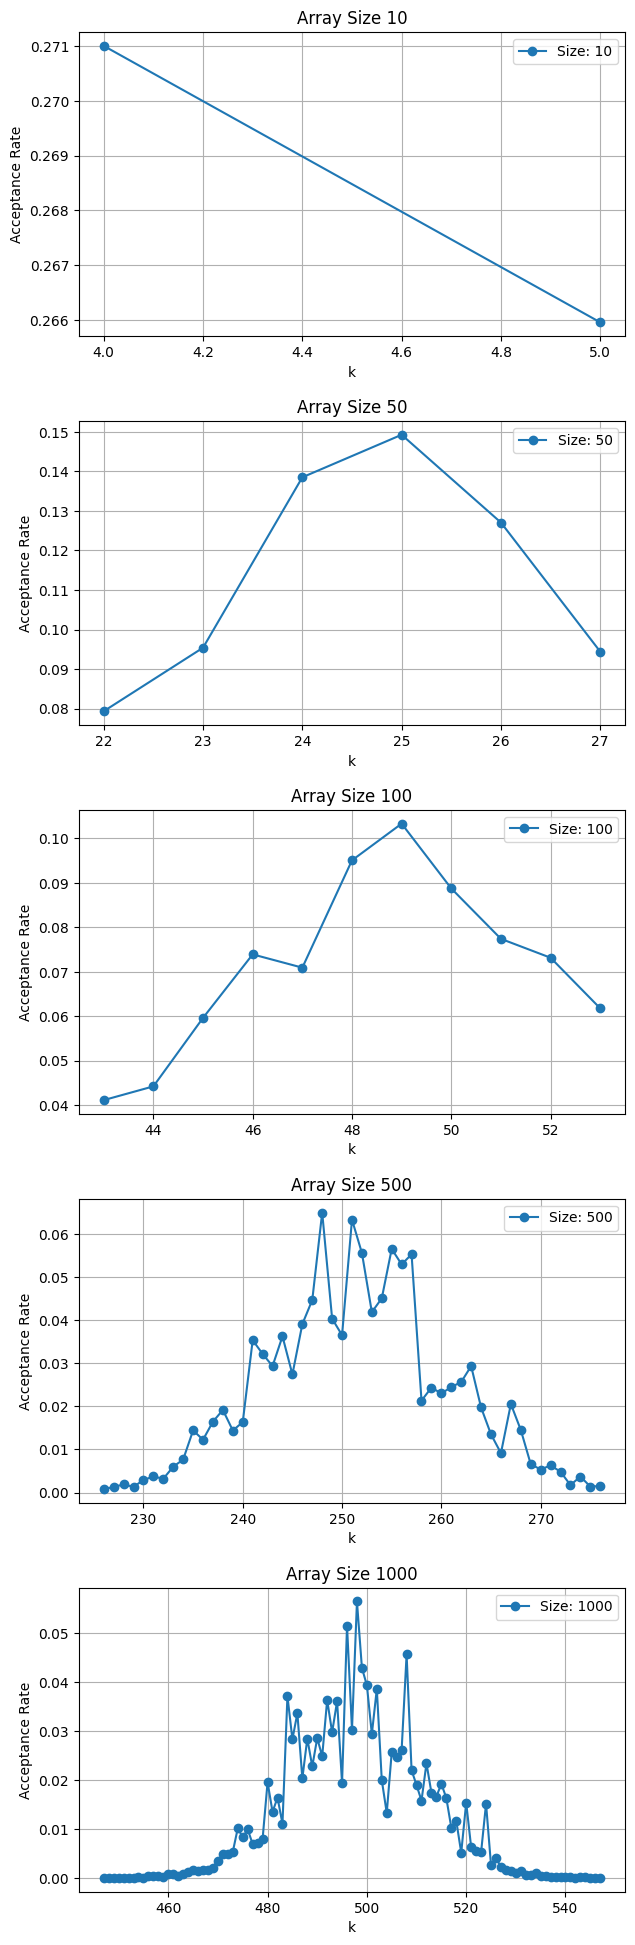

In [30]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=len(acceptance_rates), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

# Iterate over the sizes and their corresponding k_dict
for ax, (size, k_dict) in zip(axes, acceptance_rates.items()):
    k_values = list(k_dict.keys())
    rates = list(k_dict.values())
    
    ax.plot(k_values, rates, marker='o', label=f'Size: {size}')
    ax.set_xlabel('k')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.legend()
    ax.grid(True)

plt.show()



### As $N \to \infty$

As the number of Bernoulli trials $N$ approaches infinity, the probability $P(S = k)$, where $S$ is the sum of the Bernoulli random variables, appears to converge towards a normal distribution.


### Acceptance rate for varying variances

In [ ]:
from tqdm import tqdm
acceptance_rates_variance = {}

for size in [10, 100, 1000, 10000]:
    print(f"Size: {size}")
    random_arrays = [np.random.rand(size) for _ in range(5000)]
    variances = [np.var(arr) for arr in random_arrays]

    # Sort arrays by variance and extract
    sorted_indices = np.argsort(variances)[::(len(variances)) // 50]
    sorted_arrays = [random_arrays[i] for i in sorted_indices]

    # Calculate acceptance rates for each array
    acceptance_rates_variance[size] = {}
    for arr in tqdm(sorted_arrays):
        samples, attempts = rejection_sampler(arr, int(np.sum(arr)), n_samples=100)
        acceptance_rate = samples.shape[0] / attempts
        acceptance_rates_variance[size][np.var(arr)] = acceptance_rate





Size: 10


100%|██████████| 50/50 [00:00<00:00, 1038.07it/s]


Size: 100


100%|██████████| 50/50 [00:00<00:00, 386.90it/s]


Size: 1000


100%|██████████| 50/50 [00:01<00:00, 47.09it/s]


Size: 10000


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


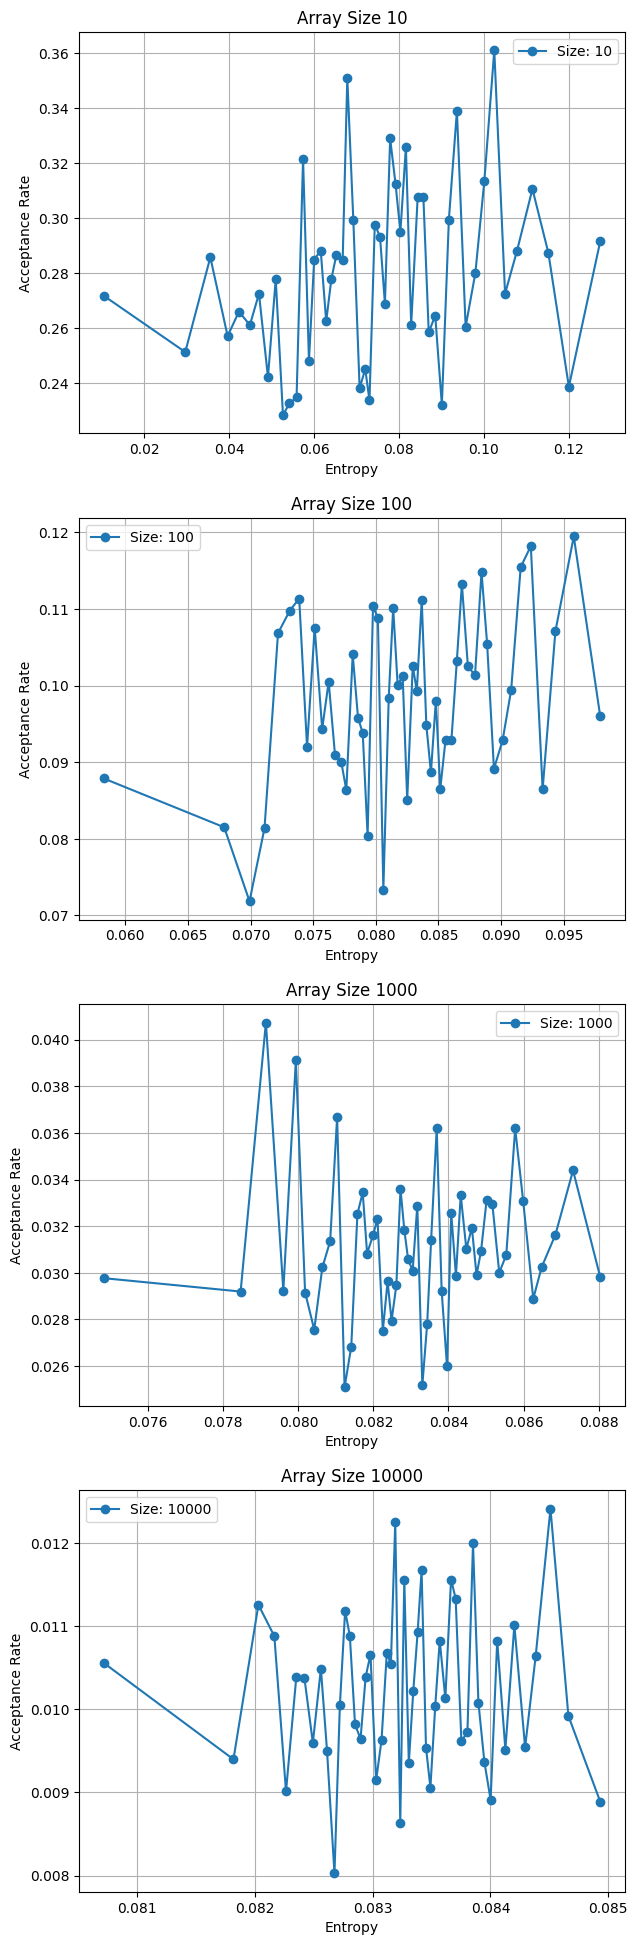

In [172]:

import matplotlib.pyplot as plt
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=len(acceptance_rates_variance), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

# Iterate over the sizes and their corresponding entropy dictionaries
for ax, (size, variance_dict) in zip(axes, acceptance_rates_variance.items()):
    entropy_values = list(variance_dict.keys())
    rates = list(variance_dict.values())
    
    ax.plot(entropy_values, rates, marker='o', label=f'Size: {size}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.legend()
    ax.grid(True)

plt.show()

## II-Exact algorithm approach

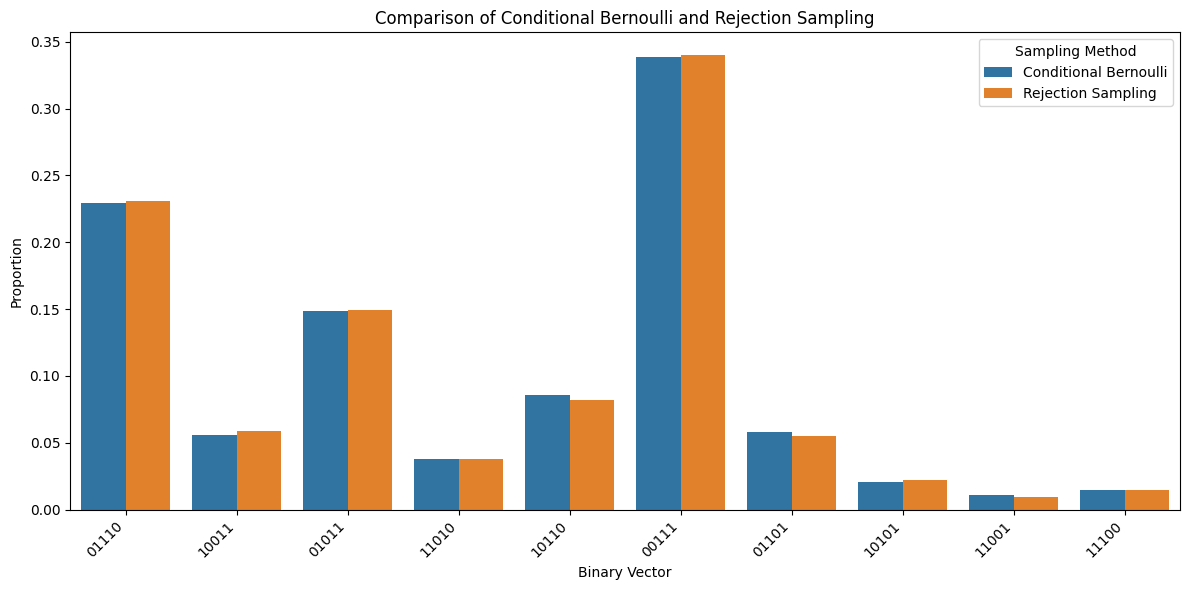

In [167]:
from collections import Counter
import seaborn as sns
import pandas as pd

def sample_conditional_bernoulli(p, I):
    """
    Samples from independent Bernoulli(p_i) variables conditioned on sum == I
    using the exact algorithm from Appendix A of Heng, Jacob, and Ju (2020).

    Parameters:
    - p: array-like of length N with values in (0,1)
    - I: integer, target sum of the Bernoulli vector

    Returns:
    - x: binary numpy array of length N such that sum(x) == I
    """
    p = np.asarray(p)
    N = len(p)

    # Initialize q table: q[i][n] = P(sum_{m=n}^N X_m = i)
    q = np.zeros((I + 2, N + 2))  # extra row and column for indexing convenience
    q[0, N + 1] = 1.0  # q(0, N+1) = 1

    # Step 1: compute q(0, n) recursively
    for n in range(N, 0, -1):
        q[0, n] = (1 - p[n - 1]) * q[0, n + 1]

    # Step 2: recursive computation for i = 1 to I
    for i in range(1, I + 1):
        q[i, N + 1] = 0.0  # initialize base case
        for n in range(N, 0, -1):
            q[i, n] = (1 - p[n - 1]) * q[i, n + 1]
            if i - 1 >= 0:
                q[i, n] += p[n - 1] * q[i - 1, n + 1]

    # Step 3: sample x sequentially
    x = np.zeros(N, dtype=int)
    remaining = I
    for n in range(1, N + 1):
        if remaining == 0:
            break  # fill the rest with zeros
        denom = q[remaining, n]
        if denom == 0:
            continue  # numerical safeguard
        num = p[n - 1] * q[remaining - 1, n + 1]
        r = num / denom
        x_n = np.random.rand() < r
        x[n - 1] = x_n
        if x_n:
            remaining -= 1

    return x



# Fixed p array of size 5
p_fixed = np.array([0.2, 0.4, 0.6, 0.8, 0.5])
k_fixed = 3

# Generate 10000 samples using conditional Bernoulli
conditional_samples = [tuple(sample_conditional_bernoulli(p_fixed, k_fixed)) for _ in range(10000)]
conditional_counts = Counter(conditional_samples)

# Generate 10000 samples using rejection sampling
rejection_samples, _ = rejection_sampler(p_fixed, k_fixed, n_samples=10000)
rejection_samples = [tuple(sample) for sample in rejection_samples]
rejection_counts = Counter(rejection_samples)



# Extract unique samples and their counts for both methods
conditional_x = list(conditional_counts.keys())
conditional_y = list(conditional_counts.values())

rejection_x = list(rejection_counts.keys())
# Sort the samples in the same order
rejection_x = [[int(val) for val in sample] for sample in rejection_x]
rejection_x_sorted = [list(sample) for sample in conditional_x if list(sample) in rejection_x]
rejection_x = rejection_x_sorted
rejection_y = [rejection_counts[tuple(sample)] for sample in conditional_x]

# Normalize the counts for both methods
conditional_y_normalized = [count / sum(conditional_y) for count in conditional_y]
rejection_y_normalized = [count / sum(rejection_y) for count in rejection_y]

# Prepare data for KDE plot
# Prepare data for plotting
plot_data = pd.DataFrame({
    'Vector': [''.join(map(str, map(int, vec))) for vec in conditional_x],
    'Conditional Bernoulli': conditional_y_normalized,
    'Rejection Sampling': rejection_y_normalized
})

# Melt the data for seaborn compatibility
plot_data_melted = plot_data.melt(id_vars='Vector', var_name='Method', value_name='Proportion')
# Create a DataFrame for seaborn
kde_data = pd.DataFrame({
    'Sample': ['Conditional Bernoulli'] * len(conditional_y_normalized) + ['Rejection Sampling'] * len(rejection_y_normalized),
    'Probability': conditional_y_normalized + rejection_y_normalized
})

# Plot the proportions using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data_melted, x='Vector', y='Proportion', hue='Method')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Binary Vector')
plt.ylabel('Proportion')
plt.title('Comparison of Conditional Bernoulli and Rejection Sampling')
plt.legend(title='Sampling Method')
plt.tight_layout()
plt.show()
